In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

# Import Drive folder

In [ ]:
#Mounting Google Drive:
from google.colab import drive
drive.mount('/content/drive/', force_remount = False)

#Drive path (for checkpoints):
drpath = "/content/drive/My Drive/Advanced_CV_Project/Code/Checkpoints"

#INFERENCE-MODE TOGGLE:
#False to train model again.
#True to load checkpoints saved during last training.
pretrained = False

Mounted at /content/drive/


#Preparing Hyperparameters

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.0003
EPOCHS = 50
BATCH_SIZE = 32

#Downloading Dataset called DIODE (A Dense Indoor and Outdoor Depth Dataset)

In [ ]:
annotation_folder = "/dataset_diode/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
  annotation_zip = keras.utils.get_file(
      "val.tar.gz",
      cache_subdir = os.path.abspath("."),
      origin = "http://diode-dataset.s3.amazonaws.com/val.tar.gz",
      extract = True,)

2774638592/2774625282 [==============================] - 69s 0us/step


#Preparing Dataset
Only indoor images are used to obtain depth estimation

In [ ]:
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
  for file in files:
    filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42)

#Building a data pipeline

The pipeline takes a dataframe containing the path for the RGB images, as well as the depth and depth mask files.

It reads and resize the RGB images.

It reads the depth and depth mask files, process them to generate the depth map image and resize it.

It returns the RGB images and the depth map images for a batch.


In [ ]:
import re
class DataGenerator(keras.utils.Sequence):
  def __init__(self, data, batch_size = 6, dim=(768,1024), n_channels = 3, shuffle = True):
    """
    Initialization
    """
    self.data = data
    self.indices = self.data.index.tolist()
    self.dim = dim
    self.n_channels = n_channels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.min_depth = 0.1
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.data) / self.batch_size))

  def __getitem__(self, index):
    if (index + 1) * self.batch_size > len(self.indices):
      self.batch_size = len(self.indices) - index * self.batch_size
    # Generate one batch of data
    # Generate indices of the batch
    index = self.indices[index * self.batch_size : (index + 1) *self.batch_size]
    batch = [self.indices[k] for k in index]
    x,y = self.data_generation(batch)

    return x, y

  def on_epoch_end(self):
    """
    Updates indexes after each epoch
    """
    self.index = np.arange(len(self.indices))
    if self.shuffle == True:
      np.random.shuffle(self.index)

  def load(self, image_path, depth_map, mask):
    """Load input and target  image."""
    image_ = cv2.imread(image_path)
    image_ = cv2.cvtColor(image_,cv2.COLOR_BGR2RGB)
    image_ = cv2.resize(image_, self.dim)
    image_ = tf.image.convert_image_dtype(image_, tf.float32)

    depth_map = np.load(depth_map).squeeze()

    mask = np.load(mask)
    mask = mask > 0

    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map,self.min_depth, max_depth)
    depth_map = np.log(depth_map, where= mask)

    depth_map = np.ma.masked_where(~mask, depth_map)

    depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
    depth_map = cv2.resize(depth_map, self.dim)
    depth_map = np.expand_dims(depth_map, axis=2)
    depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

    return image_, depth_map

  def data_generation(self, batch):

    x = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size, *self.dim,1))

    for i, batch_id in enumerate(batch):
      x[i,], y[i,] = self.load(
          self.data["image"][batch_id],
          self.data["depth"][batch_id],
          self.data["mask"][batch_id],
      )

    return x, y

#Visualizing Samples

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)


Output hidden; open in https://colab.research.google.com to view.

#3D point cloud visualization

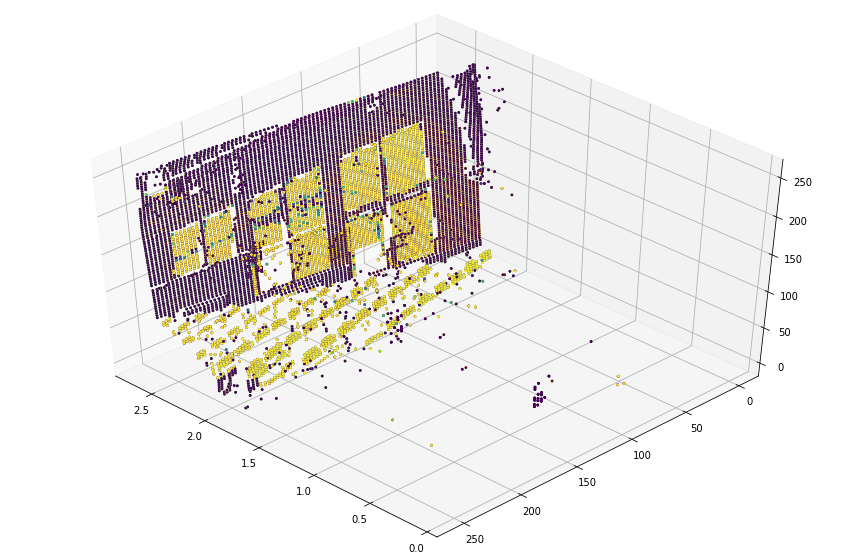

In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())
img_vis = np.flipud(visualize_samples[0][1].squeeze())

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
  for y in range(0, img_vis.shape[1], STEP):
    ax.scatter(
        [depth_vis[x, y]] * 3,
        [y] * 3,
        [x] * 3,
        c = tuple(img_vis[x,y, :3] / 255),
        s = 3,
    )
  ax.view_init(45,135)

#Building the model

The basic model is from U-Net.

Addditive skip-connections are implemented in the downscaling block.


In [ ]:
class DownscaleBlock(keras.layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = keras.layers.LeakyReLU(alpha=0.2)
        self.reluB = keras.layers.LeakyReLU(alpha=0.2)
        self.bn2a = keras.layers.BatchNormalization()
        self.bn2b = keras.layers.BatchNormalization()

        self.pool = keras.layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(keras.layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = keras.layers.UpSampling2D((2, 2))
        self.convA = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = keras.layers.LeakyReLU(alpha=0.2)
        self.reluB = keras.layers.LeakyReLU(alpha=0.2)
        self.bn2a = keras.layers.BatchNormalization()
        self.bn2b = keras.layers.BatchNormalization()
        self.conc = keras.layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(keras.layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = keras.layers.LeakyReLU(alpha=0.2)
        self.reluB = keras.layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


#Defining the loss
We will optimize 3 losses in our mode. 
1. Structural similarity index(SSIM). 
2. L1-loss, or Point-wise depth in our case. 
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [ ]:
class DepthEstimationModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = keras.layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        # Total loss
        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


#Model Compiling & Traning

In [ ]:
#CHECKPOINTS:
#Create a single collection of TensorFlow checkpoint files that are updated at the end of each epoch:
checkpoint_path = drpath+"/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights (only save if metric is improved):
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              save_weights_only=True,
                                              verbose=1,
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              mode='min')

#EARLY STOP:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            mode='min', 
                                            patience=5, 
                                            restore_best_weights=True)

In [ ]:
#MODEL:
#Defining the optimizer
optimizer = keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)

#Defining the loss function
cross_entropy  = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

#Model:
model=DepthEstimationModel()

In [ ]:
#Compile the model:
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

In [ ]:
#A) TRAINING MODE:
if pretrained == False:
  print("Training start.")
  #Training mode:
  model.fit(
      train_loader,
      epochs=EPOCHS,
      validation_data = validation_loader,
      verbose=1,
      callbacks=[cp_callback, es_callback]) # Pass callbacks to training

  # This may generate warnings related to saving the state of the optimizer.
  # These warnings (and similar warnings throughout this notebook) are in place to discourage outdated usage, and can be ignored.

Training start.
Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.0757
Epoch 00001: val_loss improved from inf to 1.56020, saving model to /content/drive/My Drive/Advanced_CV_Project/Code/Checkpoints/cp.ckpt
9/9 [==============================] - 99s 8s/step - loss: 1.0757 - val_loss: 1.5602
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.7240
Epoch 00002: val_loss improved from 1.56020 to 1.17377, saving model to /content/drive/My Drive/Advanced_CV_Project/Code/Checkpoints/cp.ckpt
9/9 [==============================] - 43s 5s/step - loss: 0.7240 - val_loss: 1.1738
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5717
Epoch 00003: val_loss did not improve from 1.17377
9/9 [==============================] - 44s 5s/step - loss: 0.5717 - val_loss: 1.3796
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.5152
Epoch 00004: val_loss improved from 1.17377 to 0.85415, saving model to /content/drive/My Drive/Advanced_CV_

In [ ]:
#B) INFERENCE MODE:
if pretrained == True:
  #Inference mode only (loads the weights from latest checkpoint):
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(latest)
  print("Latest checkpoint loaded.")

  #To visualize the collection of TensorFlow checkpoint files:
  #os.listdir(checkpoint_dir)

#Visualizing model output

We visualize the model output over the validation set. The first image is the RGB image, the second image is the ground truth depth map image and the third one is the predicted depth map image.

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.summary()

Model: "depth_estimation_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 downscale_block (DownscaleB  multiple                 2896      
 lock)                                                           
                                                                 
 downscale_block_1 (Downscal  multiple                 14144     
 eBlock)                                                         
                                                                 
 downscale_block_2 (Downscal  multiple                 55936     
 eBlock)                                                         
                                                                 
 downscale_block_3 (Downscal  multiple                 222464    
 eBlock)                                                         
                                                                 
 bottle_neck_block (BottleNe  multiple      

In [ ]:
#Convert Keras model to tflite model
tflite_model_name = 'sine_model'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimization = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzm69fc8v/assets


INFO:tensorflow:Assets written to: /tmp/tmpzm69fc8v/assets


7878168

In [ ]:
#Convertating a RAW bit into C array
#Function: Convert hex value into an array for C prpgramming

def hex_to_c_array(hex_data, var_name):

  c_str =''

  #Create header guard
  c_str  += 'aifndef' + var_name.upper() + '_H\n'
  c_str  += 'define' + var_name.upper() + '_H\n'

  #Add array lenght at the top of file
  c_str  += '\nunsigned int' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char' + var_name + '[] = {'
  hex_array= []
  for i, val in enumerate(hex_data):

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1)<len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n'
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n' + format(' '.join(hex_array)) + '/n};\n\n'

  # Close out header guard
  c_str += '#endif //' +var_name.upper() + '_H'

  return c_str


In [ ]:
# Write TFLite model to a C sourse (or header) file 
# Creat a .h file and insert this constant array their
c_model_name = 'sine_model'
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))